<a href="https://colab.research.google.com/github/moodychinsaki/MLprojectt/blob/main/ModelCV5fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ModelCV-5fold

In [1]:
import os
from os import listdir, makedirs
from os.path import isfile, join
import pandas as pd
from PIL import Image
import glob
from pathlib import Path
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.optimizers import SGD, RMSprop
import cv2
from os.path import isfile,join, exists
import zipfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import statistics as st
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import gc
from sklearn.model_selection import KFold, train_test_split
import pickle





In [2]:
pip uninstall keras-preprocessing -y

Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2


In [3]:
pip install -q -U git+https://github.com/keras-team/keras-preprocessing.git

  Preparing metadata (setup.py) ... done


In [4]:
pip install -q -U keras-tuner

In [5]:
import keras_tuner as kt

## Get the data from cloud

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/CatsDogs.zip', 'r') # Open the zip file containing all the images
zip_ref.extractall('/tmp') # Extract the file in /tmp folder
zip_ref.close()

## Removing corrupted images

In [8]:
# Assignment of paths
cat_path = glob.glob("./../tmp/CatsDogs/Cats/*.jpg")
dog_path = glob.glob("./../tmp/CatsDogs/Dogs/*.jpg")
paths = list([cat_path, dog_path])

In [9]:
#  generic code for removing corrupted images
num_skipped = 0
total = 0
for path in paths:
  for filename in path:
    if os.path.exists(filename):
      try:
        total += 1
        with open(filename, "rb") as fobj:
          is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
      except IOError:
        pass
      if not is_jfif:
        num_skipped += 1
        # Deleting corrupted image
        os.remove(filename)
 



**Concatanete data frames **
not stratifying this time

In [10]:
df_cat = pd.DataFrame({"img_name": [f"/tmp/CatsDogs/Cats/{i}" for i in os.listdir('/tmp/CatsDogs/Cats')]})
df_cat["label"] = "cat"
df_dog = pd.DataFrame({"img_name": [f"/tmp/CatsDogs/Dogs/{i}" for i in os.listdir('/tmp/CatsDogs/Dogs')]})
df_dog["label"] = "dog"
mixedF = pd.concat([df_cat, df_dog], ignore_index=True)
mixedF = mixedF.sample(frac=1, random_state = 789).reset_index(drop=True) # shuffles and drops old index, shuffle is reproducable

In [11]:
# Splits as training set and test set
trainPlusval_df, test_df = train_test_split(mixedF, test_size=0.2, random_state = 789)
     

# Splits training set into training and validation set (15% validation)
train_df, val_df = train_test_split(trainPlusval_df, test_size=0.15, random_state = 789)

Data generators to prevent ram crashes on **Colab** free plan

In [12]:
image_size = (160,160,3) # increased to 160x160 for model2hypt

In [13]:
# Data Generators for normalising images
imag_gen = ImageDataGenerator(rescale=1/255) 

In [14]:
# flow_from_dataframe method of ImageDataGenerator creates data generators for training, validation, and testing
trainPlusvalid_gen = imag_gen.flow_from_dataframe(dataframe=trainPlusval_df, 
                                                            directory=None, x_col="img_name",
                                                            y_col="label",
                                                            batch_size=90, seed=789, #batch size 90 for model2hypt
                                                            shuffle=True, class_mode="binary", 
                                                            target_size=image_size[0:2]) # img size decreased to 160x160

test_gen = imag_gen.flow_from_dataframe(dataframe = test_df, directory=None,
                                                          x_col="img_name", y_col="label",
                                                          batch_size=90, 
                                                          seed=789, shuffle=True, class_mode="binary",
                                                          target_size=image_size[0:2])

train_gen = imag_gen.flow_from_dataframe(dataframe=train_df, 
                                                            directory=None, x_col="img_name",
                                                            y_col="label",
                                                            batch_size=90, seed=789,
                                                            shuffle=True, class_mode="binary", 
                                                            target_size=image_size[0:2])

valid_gen = imag_gen.flow_from_dataframe(dataframe= val_df, 
                                                            directory=None, x_col="img_name",
                                                            y_col="label",
                                                            batch_size=90, seed=789,
                                                            shuffle=True, class_mode="binary", # 0 or 1 labels cats or dog
                                                            target_size=image_size[0:2])

Found 18728 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Found 15918 validated image filenames belonging to 2 classes.
Found 2810 validated image filenames belonging to 2 classes.


Model CV (5-fold) 

In [15]:
import scipy as scipy
from multiprocessing import Queue
import sklearn
import pandas as pd
import numpy as np
import datetime
from PIL import Image # to open images
import os
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import shutil


In [17]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom
from tensorflow.keras.layers import Dropout
modelCV = Sequential(name="MODEL_CV")
#Data Augmentation
modelCV.add(RandomFlip('horizontal'))
modelCV.add(RandomRotation(0.15))
modelCV.add(RandomZoom(0.15))
# add padding to the first Conv2D layer
modelCV.add(Conv2D(32, (3, 3), strides=(2, 2) ,input_shape=image_size, padding='valid'))  
modelCV.add(Activation('relu'))
modelCV.add(MaxPooling2D(pool_size=(2, 2))) 

modelCV.add(Conv2D(128, (3, 3), strides=(2, 2), padding='valid' ))
modelCV.add(Activation('relu'))
modelCV.add(MaxPooling2D(pool_size=(2, 2)))
# added hidden layer model2hypt
modelCV.add(Conv2D(256, (3, 3), strides=(2, 2), padding='valid'))
modelCV.add(Activation('relu'))
modelCV.add(MaxPooling2D(pool_size=(2, 2)))
#Dropout
modelCV.add(Dropout(0.25))

modelCV.add(Flatten())  
modelCV.add(Dense(32))
#Dropout
modelCV.add(Dropout(0.30))

modelCV.add(Dense(1))
modelCV.add(Activation('sigmoid'))



In [18]:
model_cv=modelCV

In [19]:
model_cv_checkpoint = ModelCheckpoint("Model_CV", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")


In [20]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 789)
kfVal = KFold(n_splits = 5, shuffle = True, random_state = 789)

# loop for 5fold cv with 20 epochs per fold
for val_train_index, test_index in kf.split(mixedF):
    # Splitted before as training set and test set --- trainPlusval and test set
    val_train, df_test = mixedF.iloc[val_train_index], mixedF.iloc[test_index]
    
    train, validation = next(kfVal.split(val_train))
    
    # Splitted before training set into training and validation set (15% validation)
    df_train, df_validation = val_train.iloc[train], val_train.iloc[validation]
   

    # GENERATORS
    train_data_generator = imag_gen.flow_from_dataframe(df_train, 
                                                   directory = None,
                                                   x_col = "img_name", 
                                                   y_col = "label",
                                                   class_mode = "binary", 
                                                   shuffle = True,
                                                   seed = 789,
                                                   target_size=image_size[0:2], 
                                                   batch_size = 90),
    
    valid_data_generator  = imag_gen.flow_from_dataframe(df_validation, 
                                                    directory = None, 
                                                    x_col = "img_name",
                                                    y_col = "label",
                                                    class_mode = "binary", 
                                                    shuffle = True,
                                                    seed = 789,
                                                    target_size=image_size[0:2], # img size decreased to 160x160
                                                    batch_size = 90),
    
    test_data_generator = imag_gen.flow_from_dataframe(df_test, 
                                                  directory = None, 
                                                  seed = 789,
                                                  x_col = "img_name",
                                                  y_col = "label",
                                                  class_mode = "binary", 
                                                  shuffle = True, 
                                                  target_size=image_size[0:2], # img size decreased to 160x160)
                                                  batch_size = 90),
      # Compile the model
    model_cv.compile(loss='binary_crossentropy',
                   optimizer="adam",
                    metrics=['accuracy'])
                                            
      #  FIT the modelCV
    fitCV =  model_cv.fit(train_gen,
                    validation_data = valid_gen,
                    steps_per_epoch = train_gen.n//train_gen.batch_size,
                    validation_steps = valid_gen.n//valid_gen.batch_size,
                    epochs = 20,
                    callbacks = [model_cv_checkpoint])

Found 14982 validated image filenames belonging to 2 classes.
Found 3746 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Epoch 1/20
176/176 [==============================] - ETA: 0s - loss: 0.6717 - accuracy: 0.5693
Epoch 1: val_accuracy improved from -inf to 0.65305, saving model to Model_CV


176/176 [==============================] - 86s 467ms/step - loss: 0.6717 - accuracy: 0.5693 - val_loss: 0.6157 - val_accuracy: 0.6530
Epoch 2/20
176/176 [==============================] - ETA: 0s - loss: 0.6122 - accuracy: 0.6652
Epoch 2: val_accuracy improved from 0.65305 to 0.72043, saving model to Model_CV


176/176 [==============================] - 70s 399ms/step - loss: 0.6122 - accuracy: 0.6652 - val_loss: 0.5600 - val_accuracy: 0.7204
Epoch 3/20
176/176 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.7122
Epoch 3: val_accuracy did not improve from 0.72043
176/176 [==============================] - 63s 357ms/step - loss: 0.5645 - accuracy: 0.7122 - val_loss: 0.5792 - val_accuracy: 0.6832
Epoch 4/20
176/176 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.7164
Epoch 4: val_accuracy did not improve from 0.72043
176/176 [==============================] - 62s 354ms/step - loss: 0.5524 - accuracy: 0.7164 - val_loss: 0.6111 - val_accuracy: 0.6835
Epoch 5/20
176/176 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.7427
Epoch 5: val_accuracy improved from 0.72043 to 0.73692, saving model to Model_CV


176/176 [==============================] - 65s 371ms/step - loss: 0.5227 - accuracy: 0.7427 - val_loss: 0.5209 - val_accuracy: 0.7369
Epoch 6/20
176/176 [==============================] - ETA: 0s - loss: 0.5109 - accuracy: 0.7563
Epoch 6: val_accuracy improved from 0.73692 to 0.75986, saving model to Model_CV


176/176 [==============================] - 65s 367ms/step - loss: 0.5109 - accuracy: 0.7563 - val_loss: 0.4878 - val_accuracy: 0.7599
Epoch 7/20
176/176 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.7599
Epoch 7: val_accuracy improved from 0.75986 to 0.77670, saving model to Model_CV


176/176 [==============================] - 66s 373ms/step - loss: 0.4947 - accuracy: 0.7599 - val_loss: 0.4751 - val_accuracy: 0.7767
Epoch 8/20
176/176 [==============================] - ETA: 0s - loss: 0.4872 - accuracy: 0.7628
Epoch 8: val_accuracy improved from 0.77670 to 0.78961, saving model to Model_CV


176/176 [==============================] - 65s 371ms/step - loss: 0.4872 - accuracy: 0.7628 - val_loss: 0.4416 - val_accuracy: 0.7896
Epoch 9/20
176/176 [==============================] - ETA: 0s - loss: 0.4685 - accuracy: 0.7775
Epoch 9: val_accuracy improved from 0.78961 to 0.80358, saving model to Model_CV


176/176 [==============================] - 65s 367ms/step - loss: 0.4685 - accuracy: 0.7775 - val_loss: 0.4272 - val_accuracy: 0.8036
Epoch 10/20
176/176 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.7834
Epoch 10: val_accuracy did not improve from 0.80358
176/176 [==============================] - 61s 346ms/step - loss: 0.4599 - accuracy: 0.7834 - val_loss: 0.4268 - val_accuracy: 0.8011
Epoch 11/20
176/176 [==============================] - ETA: 0s - loss: 0.4495 - accuracy: 0.7898
Epoch 11: val_accuracy improved from 0.80358 to 0.80896, saving model to Model_CV


176/176 [==============================] - 63s 357ms/step - loss: 0.4495 - accuracy: 0.7898 - val_loss: 0.4109 - val_accuracy: 0.8090
Epoch 12/20
176/176 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.7887
Epoch 12: val_accuracy did not improve from 0.80896
176/176 [==============================] - 61s 344ms/step - loss: 0.4448 - accuracy: 0.7887 - val_loss: 0.4252 - val_accuracy: 0.8000
Epoch 13/20
176/176 [==============================] - ETA: 0s - loss: 0.4415 - accuracy: 0.7947
Epoch 13: val_accuracy did not improve from 0.80896
176/176 [==============================] - 63s 359ms/step - loss: 0.4415 - accuracy: 0.7947 - val_loss: 0.4721 - val_accuracy: 0.7785
Epoch 14/20
176/176 [==============================] - ETA: 0s - loss: 0.4289 - accuracy: 0.8049
Epoch 14: val_accuracy did not improve from 0.80896
176/176 [==============================] - 63s 358ms/step - loss: 0.4289 - accuracy: 0.8049 - val_loss: 0.4124 - val_accuracy: 0.8090
Epoch 15/20
176/1

176/176 [==============================] - 62s 355ms/step - loss: 0.4165 - accuracy: 0.8103 - val_loss: 0.4066 - val_accuracy: 0.8133
Epoch 16/20
176/176 [==============================] - ETA: 0s - loss: 0.4100 - accuracy: 0.8131
Epoch 16: val_accuracy improved from 0.81326 to 0.82903, saving model to Model_CV


176/176 [==============================] - 64s 363ms/step - loss: 0.4100 - accuracy: 0.8131 - val_loss: 0.3786 - val_accuracy: 0.8290
Epoch 17/20
176/176 [==============================] - ETA: 0s - loss: 0.4055 - accuracy: 0.8195
Epoch 17: val_accuracy did not improve from 0.82903
176/176 [==============================] - 61s 347ms/step - loss: 0.4055 - accuracy: 0.8195 - val_loss: 0.3830 - val_accuracy: 0.8211
Epoch 18/20
176/176 [==============================] - ETA: 0s - loss: 0.4031 - accuracy: 0.8168
Epoch 18: val_accuracy improved from 0.82903 to 0.83441, saving model to Model_CV


176/176 [==============================] - 65s 368ms/step - loss: 0.4031 - accuracy: 0.8168 - val_loss: 0.3683 - val_accuracy: 0.8344
Epoch 19/20
176/176 [==============================] - ETA: 0s - loss: 0.3855 - accuracy: 0.8276
Epoch 19: val_accuracy did not improve from 0.83441
176/176 [==============================] - 62s 354ms/step - loss: 0.3855 - accuracy: 0.8276 - val_loss: 0.3991 - val_accuracy: 0.8165
Epoch 20/20
176/176 [==============================] - ETA: 0s - loss: 0.3931 - accuracy: 0.8249
Epoch 20: val_accuracy did not improve from 0.83441
176/176 [==============================] - 61s 350ms/step - loss: 0.3931 - accuracy: 0.8249 - val_loss: 0.3916 - val_accuracy: 0.8186
Found 14982 validated image filenames belonging to 2 classes.
Found 3746 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Epoch 1/20
176/176 [==============================] - ETA: 0s - loss: 0.3740 - accuracy: 0.8305
Epoch 1: val_accurac

176/176 [==============================] - 68s 364ms/step - loss: 0.3740 - accuracy: 0.8305 - val_loss: 0.3724 - val_accuracy: 0.8380
Epoch 2/20
176/176 [==============================] - ETA: 0s - loss: 0.3736 - accuracy: 0.8352
Epoch 2: val_accuracy did not improve from 0.83799
176/176 [==============================] - 63s 356ms/step - loss: 0.3736 - accuracy: 0.8352 - val_loss: 0.3755 - val_accuracy: 0.8315
Epoch 3/20
176/176 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.8345
Epoch 3: val_accuracy improved from 0.83799 to 0.83871, saving model to Model_CV


176/176 [==============================] - 63s 357ms/step - loss: 0.3694 - accuracy: 0.8345 - val_loss: 0.3656 - val_accuracy: 0.8387
Epoch 4/20
176/176 [==============================] - ETA: 0s - loss: 0.3635 - accuracy: 0.8400
Epoch 4: val_accuracy did not improve from 0.83871
176/176 [==============================] - 63s 359ms/step - loss: 0.3635 - accuracy: 0.8400 - val_loss: 0.4042 - val_accuracy: 0.8190
Epoch 5/20
176/176 [==============================] - ETA: 0s - loss: 0.3566 - accuracy: 0.8423
Epoch 5: val_accuracy did not improve from 0.83871
176/176 [==============================] - 62s 353ms/step - loss: 0.3566 - accuracy: 0.8423 - val_loss: 0.4138 - val_accuracy: 0.8082
Epoch 6/20
176/176 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.8443
Epoch 6: val_accuracy did not improve from 0.83871
176/176 [==============================] - 61s 344ms/step - loss: 0.3548 - accuracy: 0.8443 - val_loss: 0.3735 - val_accuracy: 0.8358
Epoch 7/20
176/176 [===

176/176 [==============================] - 65s 371ms/step - loss: 0.3536 - accuracy: 0.8430 - val_loss: 0.3276 - val_accuracy: 0.8616
Epoch 9/20
176/176 [==============================] - ETA: 0s - loss: 0.3494 - accuracy: 0.8423
Epoch 9: val_accuracy did not improve from 0.86165
176/176 [==============================] - 63s 360ms/step - loss: 0.3494 - accuracy: 0.8423 - val_loss: 0.3531 - val_accuracy: 0.8462
Epoch 10/20
176/176 [==============================] - ETA: 0s - loss: 0.3414 - accuracy: 0.8502
Epoch 10: val_accuracy did not improve from 0.86165
176/176 [==============================] - 61s 349ms/step - loss: 0.3414 - accuracy: 0.8502 - val_loss: 0.3705 - val_accuracy: 0.8373
Epoch 11/20
176/176 [==============================] - ETA: 0s - loss: 0.3427 - accuracy: 0.8482
Epoch 11: val_accuracy did not improve from 0.86165
176/176 [==============================] - 63s 356ms/step - loss: 0.3427 - accuracy: 0.8482 - val_loss: 0.3446 - val_accuracy: 0.8452
Epoch 12/20
176/176

176/176 [==============================] - 64s 365ms/step - loss: 0.3164 - accuracy: 0.8614 - val_loss: 0.3092 - val_accuracy: 0.8695
Found 14982 validated image filenames belonging to 2 classes.
Found 3746 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Epoch 1/20
176/176 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.8646
Epoch 1: val_accuracy did not improve from 0.86953
176/176 [==============================] - 65s 359ms/step - loss: 0.3161 - accuracy: 0.8646 - val_loss: 0.3188 - val_accuracy: 0.8638
Epoch 2/20
176/176 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.8601
Epoch 2: val_accuracy did not improve from 0.86953
176/176 [==============================] - 62s 353ms/step - loss: 0.3211 - accuracy: 0.8601 - val_loss: 0.3060 - val_accuracy: 0.8677
Epoch 3/20
176/176 [==============================] - ETA: 0s - loss: 0.3086 - accuracy: 0.8651
Epoch 3: val_accuracy di

176/176 [==============================] - 66s 377ms/step - loss: 0.2968 - accuracy: 0.8740 - val_loss: 0.2903 - val_accuracy: 0.8803
Epoch 8/20
176/176 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.8712
Epoch 8: val_accuracy did not improve from 0.88029
176/176 [==============================] - 61s 346ms/step - loss: 0.2986 - accuracy: 0.8712 - val_loss: 0.3064 - val_accuracy: 0.8685
Epoch 9/20
176/176 [==============================] - ETA: 0s - loss: 0.3010 - accuracy: 0.8716
Epoch 9: val_accuracy did not improve from 0.88029
176/176 [==============================] - 63s 356ms/step - loss: 0.3010 - accuracy: 0.8716 - val_loss: 0.3100 - val_accuracy: 0.8670
Epoch 10/20
176/176 [==============================] - ETA: 0s - loss: 0.2930 - accuracy: 0.8726
Epoch 10: val_accuracy did not improve from 0.88029
176/176 [==============================] - 61s 348ms/step - loss: 0.2930 - accuracy: 0.8726 - val_loss: 0.3293 - val_accuracy: 0.8588
Epoch 11/20
176/176 [

176/176 [==============================] - 64s 365ms/step - loss: 0.2756 - accuracy: 0.8837 - val_loss: 0.2882 - val_accuracy: 0.8846
Epoch 4/20
176/176 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.8748
Epoch 4: val_accuracy did not improve from 0.88459
176/176 [==============================] - 60s 344ms/step - loss: 0.2882 - accuracy: 0.8748 - val_loss: 0.3379 - val_accuracy: 0.8627
Epoch 5/20
176/176 [==============================] - ETA: 0s - loss: 0.2772 - accuracy: 0.8820
Epoch 5: val_accuracy did not improve from 0.88459
176/176 [==============================] - 62s 351ms/step - loss: 0.2772 - accuracy: 0.8820 - val_loss: 0.3051 - val_accuracy: 0.8821
Epoch 6/20
176/176 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.8861
Epoch 6: val_accuracy did not improve from 0.88459
176/176 [==============================] - 62s 350ms/step - loss: 0.2742 - accuracy: 0.8861 - val_loss: 0.3051 - val_accuracy: 0.8710
Epoch 7/20
176/176 [===

176/176 [==============================] - 65s 368ms/step - loss: 0.2618 - accuracy: 0.8886 - val_loss: 0.2778 - val_accuracy: 0.8875
Epoch 19/20
176/176 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.8910
Epoch 19: val_accuracy did not improve from 0.88746
176/176 [==============================] - 61s 346ms/step - loss: 0.2586 - accuracy: 0.8910 - val_loss: 0.2824 - val_accuracy: 0.8789
Epoch 20/20
176/176 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.8899
Epoch 20: val_accuracy did not improve from 0.88746
176/176 [==============================] - 62s 353ms/step - loss: 0.2573 - accuracy: 0.8899 - val_loss: 0.2721 - val_accuracy: 0.8864
Found 14982 validated image filenames belonging to 2 classes.
Found 3746 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Epoch 1/20
176/176 [==============================] - ETA: 0s - loss: 0.2630 - accuracy: 0.8866
Epoch 1: val_accurac

176/176 [==============================] - 64s 364ms/step - loss: 0.2509 - accuracy: 0.8922 - val_loss: 0.2925 - val_accuracy: 0.8892
Epoch 10/20
176/176 [==============================] - ETA: 0s - loss: 0.2532 - accuracy: 0.8923
Epoch 10: val_accuracy did not improve from 0.88925
176/176 [==============================] - 62s 350ms/step - loss: 0.2532 - accuracy: 0.8923 - val_loss: 0.2886 - val_accuracy: 0.8781
Epoch 11/20
176/176 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.8942
Epoch 11: val_accuracy did not improve from 0.88925
176/176 [==============================] - 63s 359ms/step - loss: 0.2513 - accuracy: 0.8942 - val_loss: 0.2681 - val_accuracy: 0.8799
Epoch 12/20
176/176 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.8956
Epoch 12: val_accuracy did not improve from 0.88925
176/176 [==============================] - 62s 354ms/step - loss: 0.2508 - accuracy: 0.8956 - val_loss: 0.3054 - val_accuracy: 0.8703
Epoch 13/20
176/1

In [21]:
model_cv_history = []

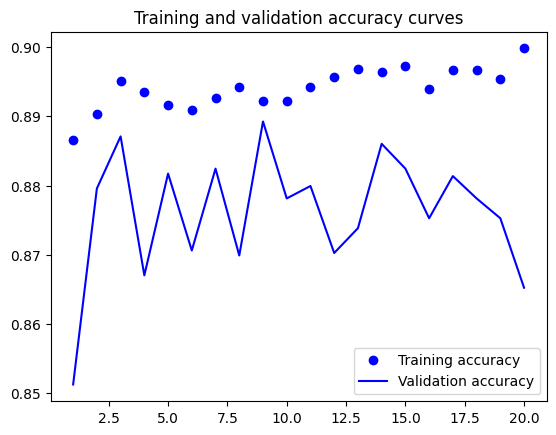

In [22]:
import matplotlib.pyplot as plt

history = fitCV.history
epochs = range(1, len(history['accuracy']) + 1)

plt.plot(epochs, history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy curves')
plt.legend()

plt.show()

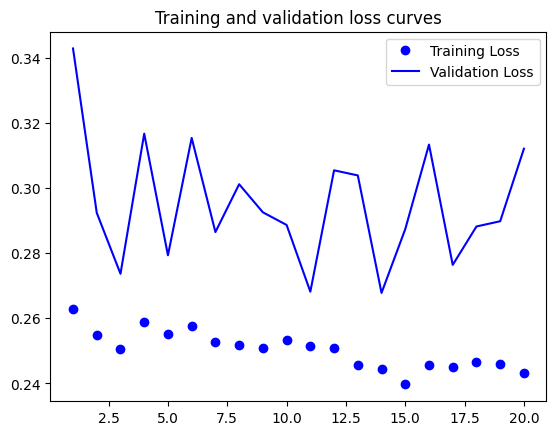

In [23]:
history = fitCV.history
epochs = range(1, len(history['loss']) + 1)

plt.plot(epochs, history['loss'], 'bo', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'b', label='Validation Loss')
plt.title('Training and validation loss curves')
plt.legend()

plt.show()

In [24]:
  # Use garbage collector for RAM and free up GPU 

  tf.keras.backend.clear_session()
  gc.collect()

25079

IndexError: ignored

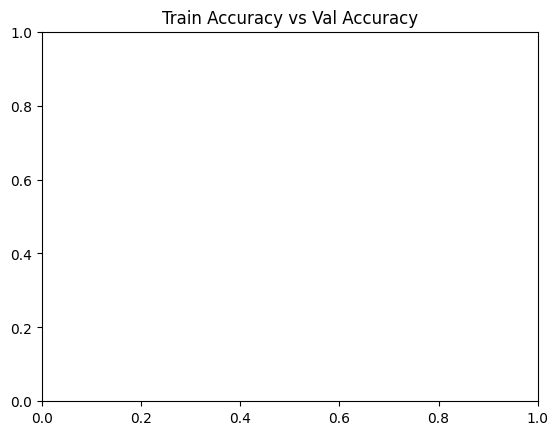

In [25]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_cv_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_cv_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")

plt.plot(model_cv_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_cv_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")

plt.plot(model_cv_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_cv_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")

plt.plot(model_cv_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(model_cv_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")

plt.plot(model_cv_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='orange', )
plt.plot(model_cv_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='orange', linestyle = "dashdot")

plt.legend()
plt.show()

In [ ]:
plt.title('Train loss vs Validation loss')


plt.plot(model_cv_history[1].history['loss'], label='Train loss Fold 2', color='red', )
plt.plot(model_cv_history[1].history['val_loss'], label='Val loss Fold 2', color='red', linestyle = "dashdot")

plt.plot(model_cv_history[2].history['loss'], label='Train loss Fold 3', color='green', )
plt.plot(model_cv_history[2].history['val_loss'], label='Val loss Fold 3', color='green', linestyle = "dashdot")

plt.plot(model_cv_history[3].history['loss'], label='Train loss Fold 4', color='blue', )
plt.plot(model_cv_history[3].history['val_loss'], label='Val loss Fold 4', color='blue', linestyle = "dashdot")


plt.legend()
plt.show()

In [ ]:
len(history)